# Forex exploration
Exploting Forex data with data visualisation and candles.

In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import psycopg2 as db_driver
import pandas.io.sql as psql
import pandas as pd
from datetime import date
import numpy as np
import matplotlib.pyplot as plt
from itertools import product
from pandas.tools.plotting import lag_plot, autocorrelation_plot
# from qsforex.data import average_spreads
conn = db_driver.connect(host="localhost",
                         dbname="forex",
                         user="oxylo",
                         password="root")

/usr/local/lib/python2.7/dist-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


In [2]:
def get_data(market, start_date, end_date, start_hour, end_hour, conn):
    """ Get data from Postgresql database.
    """
    print "Loading historical data...",
    query = """SELECT dtime, rate_open, rate_high, rate_low, rate_close
               FROM tbl_forexite
               INNER JOIN tbl_currency_pair CP ON ticker_id = CP.id
               WHERE CP.ticker = %(market)s
               AND dtime BETWEEN %(start_date)s AND %(end_date)s
               AND EXTRACT(hour from dtime) BETWEEN %(start_hour)s and %(end_hour)s
               """
    df = psql.read_sql(query, conn,
                       params={'market': market,
                               'start_date': start_date,
                               'end_date': end_date,
                               'start_hour': start_hour,
                               'end_hour': end_hour})
    print "OK"
    return df.set_index('dtime')

def create_columns_names(label, n):
    """ Returns a list with n subsequent labels, i.e. ['label0', 'label1', ... 'labeln-1']
    """
    col_names = [label + str(colnr) for colnr in range(n)]
    return col_names

def recover_missing_categories(df):
    """
    Returns given df recovering missing combinations of the index columns.
    
    Parameters:
    ----------
    df: dataframe with (multi)index. 
    """
    levels = df.index.levels
    names = df.index.names
    m = pd.MultiIndex.from_product(levels, names=names)
    df = df.reindex(m)
    return df
    

In [69]:
# input variables:
market = 'EURUSD'
price = 'rate_open'
start_date = '2016-01-01 00:00:00'
end_date = '2016-06-14 23:59:00'
start_hour = -99
end_hour = 99
sampling_interval = '1Min'
pattern_length = 3
show_results_per = 'M' 

In [70]:
df = get_data(market, start_date, end_date, start_hour, end_hour, conn)
# df.to_csv('/home/pieter/projects/quantfxengine/dev/outfile.csv', sep=';', index=True)
df_resampled = df.resample(rule=sampling_interval).first().dropna(axis=0, how='any')

Loading historical data... OK


<IPython.core.display.Javascript object>


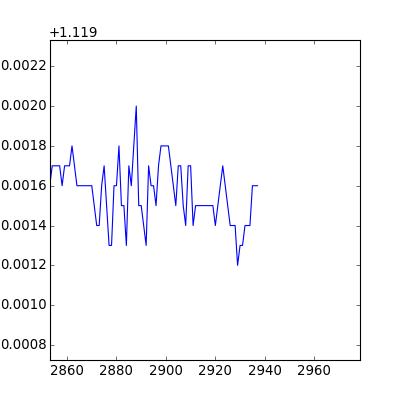

In [5]:
fig, ax = plt.subplots(figsize=(5,5))
ax.plot(df_resampled[price])

<IPython.core.display.Javascript object>


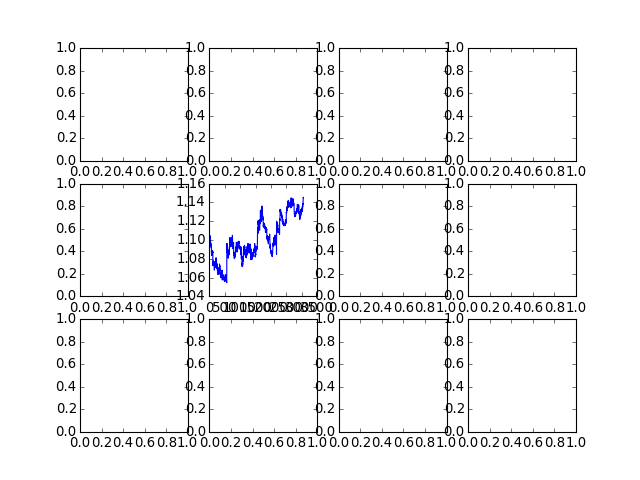

In [10]:
fig, ax = plt.subplots(3, 4)
ax[1, 1].plot(df_resampled[price])

In [23]:
rates = pd.DataFrame(df_resampled[price]).to_period(freq=show_results_per)

In [24]:
for colnr in range(pattern_length):
    rates[colnr] = rates[price].shift(-colnr-1)

In [25]:
delta_headers = create_columns_names('delta', pattern_length)
pip_headers = create_columns_names('pip', pattern_length)
differences = rates.diff(periods=1, axis=1).iloc[:-pattern_length,1:]
differences.columns = delta_headers

In [26]:
out_temp = (differences > 0).copy(deep=True)
differences.columns = pip_headers
out = pd.concat([differences, out_temp], axis=1)

In [27]:
out['ones'] = 1
out.reset_index(inplace=True)
out2 = out.groupby(['dtime'] + delta_headers).sum()
pips_change = 10000 * out2[pip_headers].div(out2.ones, axis='index')
ones_and_pips_change = pd.concat([out2['ones'], pips_change[pip_headers[-1]]], axis=1)

In [28]:
out['ones'] = 1
out.reset_index(inplace=True)
out2 = out.groupby(['dtime'] + delta_headers).sum()
pips_change = 10000 * out2[pip_headers].div(out2.ones, axis='index')
ones_and_pips_change = pd.concat([out2['ones'], pips_change[pip_headers[-1]]], axis=1)

In [29]:
recovered = recover_missing_categories(ones_and_pips_change)

In [30]:
last_delta = delta_headers[-1]
recovered.reset_index(last_delta, inplace=True)
result = recovered.pivot(columns=last_delta)
result.columns = ['ntimes_down', 'ntimes_up', 'pips_down', 'pips_up']

In [31]:
new_level_order = range(1, pattern_length) + [0]
prob_up = result['ntimes_up'] / (result['ntimes_down'] + result['ntimes_up'])
result['prob_up'] = 100 * prob_up.map(lambda x: round(x, 3)) 
result = result.reorder_levels(order= new_level_order, axis=0)
result.sortlevel(level=0, axis=0, inplace=True)
result['difference'] = result['ntimes_up'] - result['ntimes_down']

In [32]:
grp = result.groupby(level=delta_headers[:-1])
end_result = pd.concat([grp['difference'].agg([np.mean, np.std, 'count']),
                       grp['pips_down'].agg([np.mean, np.std]),
                       grp['pips_up'].agg([np.mean, np.std]),
                       grp['prob_up'].agg([np.mean, np.std])], axis=1)
end_result.columns = ['n_up_minus_down', 'std_ntimes', 'count', 'pips_down', 'std_pdown', 'pips_up', 'std_pup',
                      'prob_up', 'std_prob']
end_result['t_value'] = end_result['n_up_minus_down'] / (end_result['std_ntimes'] / end_result['count'].map(lambda x: np.sqrt(x)))
print end_result

               n_up_minus_down  std_ntimes  count  pips_down  std_pdown  \
delta0 delta1                                                             
False  False          7.500000    8.408329      6  -7.643817   1.890948   
       True          -7.833333    8.681398      6  -7.202125   1.024772   
True   False         -6.333333    9.831921      6  -9.286764   2.314823   
       True         -11.333333    7.393691      6  -9.428325   1.161054   

                 pips_up   std_pup    prob_up  std_prob   t_value  
delta0 delta1                                                      
False  False    8.556193  0.381921  53.033333  3.530817  2.184878  
       True     9.327774  1.465731  47.083333  3.204008 -2.210205  
True   False    8.853645  2.044385  47.633333  3.745753 -1.577864  
       True    10.057086  2.261048  44.666667  3.821344 -3.754672  


In [33]:
print end_result[((np.abs(end_result['t_value'])>2.8) & (np.abs(end_result['prob_up'] - 50) > 5))]

               n_up_minus_down  std_ntimes  count  pips_down  std_pdown  \
delta0 delta1                                                             
True   True         -11.333333    7.393691      6  -9.428325   1.161054   

                 pips_up   std_pup    prob_up  std_prob   t_value  
delta0 delta1                                                      
True   True    10.057086  2.261048  44.666667  3.821344 -3.754672  


In [256]:
writer = pd.ExcelWriter('output.xlsx')
result.to_excel(writer, 'uitvoer')
writer.save()

TypeError: Unsupported type <type 'pandas._period.Period'> in write()

<IPython.core.display.Javascript object>


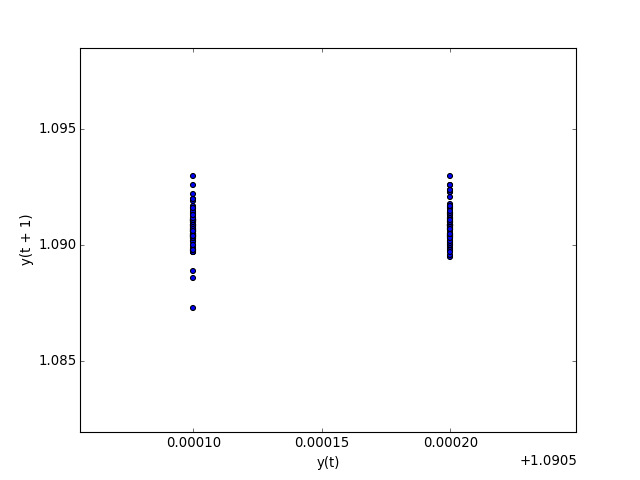

In [22]:
%matplotlib notebook
lag_plot(df_resampled)

<IPython.core.display.Javascript object>


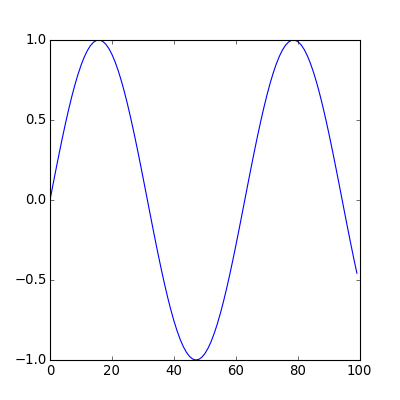

In [15]:
x = np.arange(0, 10, 0.1)
y = np.sin(x)
s = pd.Series(y)

fig, ax = plt.subplots(figsize=(5,5))
ax.plot(s)

In [14]:
print s.head(10)

0    0.000000
1    0.099833
2    0.198669
3    0.295520
4    0.389418
5    0.479426
6    0.564642
7    0.644218
8    0.717356
9    0.783327
dtype: float64


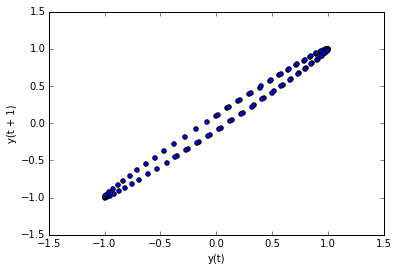

In [21]:
%matplotlib inline
lag_plot(s)

<IPython.core.display.Javascript object>


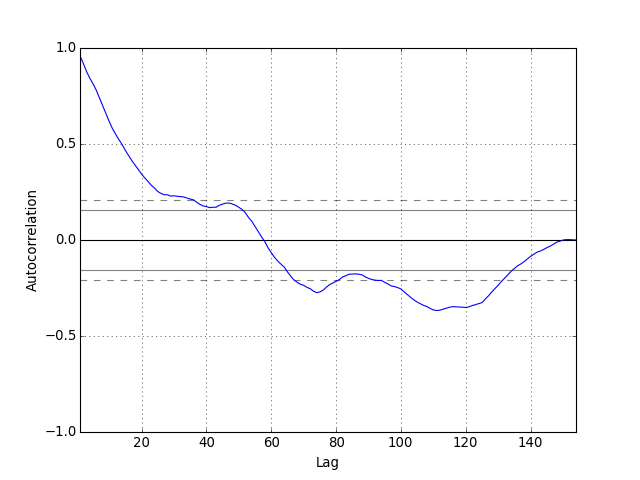

In [29]:
%matplotlib notebook
autocorrelation_plot(df_resampled)

<IPython.core.display.Javascript object>


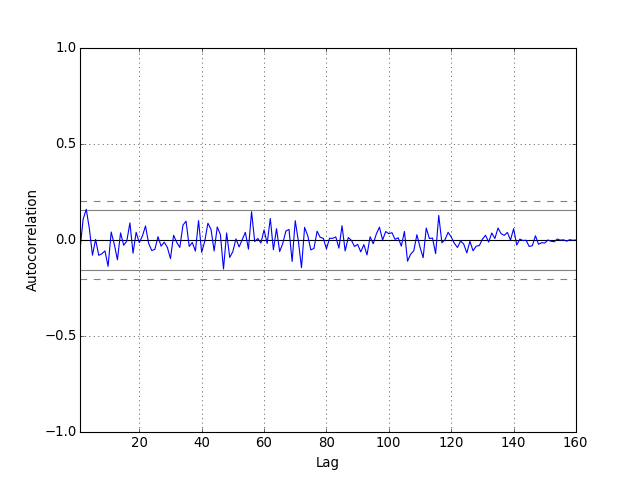

In [31]:
%matplotlib notebook
s2 = pd.Series(np.random.randn(160))
autocorrelation_plot(s2)

<IPython.core.display.Javascript object>


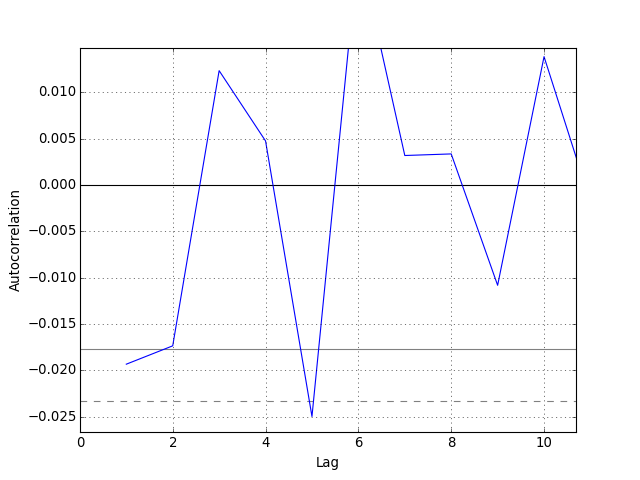

In [41]:
%matplotlib notebook
delta = df_resampled - df_resampled.shift(-1)
autocorrelation_plot(delta[:-1])

In [6]:
3  * 24 * 60

4320

In [20]:
from datetime import datetime, timedelta
print df.ix[datetime(2016, 6, 12, 23, 1)]

rate_open     1.1251
rate_high     1.1251
rate_low      1.1249
rate_close    1.1249
Name: 2016-06-12 23:01:00, dtype: float64


In [5]:
print df.head()

                     rate_open  rate_high  rate_low  rate_close
dtime                                                          
2016-06-12 23:01:00     1.1251     1.1251    1.1249      1.1249
2016-06-12 23:02:00     1.1250     1.1251    1.1250      1.1251
2016-06-12 23:03:00     1.1249     1.1249    1.1248      1.1249
2016-06-12 23:04:00     1.1249     1.1250    1.1249      1.1249
2016-06-12 23:05:00     1.1249     1.1250    1.1249      1.1250


In [6]:
df.index

DatetimeIndex(['2016-06-12 23:01:00', '2016-06-12 23:02:00',
               '2016-06-12 23:03:00', '2016-06-12 23:04:00',
               '2016-06-12 23:05:00', '2016-06-12 23:06:00',
               '2016-06-12 23:07:00', '2016-06-12 23:08:00',
               '2016-06-12 23:09:00', '2016-06-12 23:10:00',
               ...
               '2016-06-14 23:50:00', '2016-06-14 23:51:00',
               '2016-06-14 23:52:00', '2016-06-14 23:53:00',
               '2016-06-14 23:54:00', '2016-06-14 23:55:00',
               '2016-06-14 23:56:00', '2016-06-14 23:57:00',
               '2016-06-14 23:58:00', '2016-06-14 23:59:00'],
              dtype='datetime64[ns]', name=u'dtime', length=2938, freq=None)

In [16]:
  + timedelta(days=7)

datetime.datetime(2016, 6, 19, 23, 1)

<IPython.core.display.Javascript object>


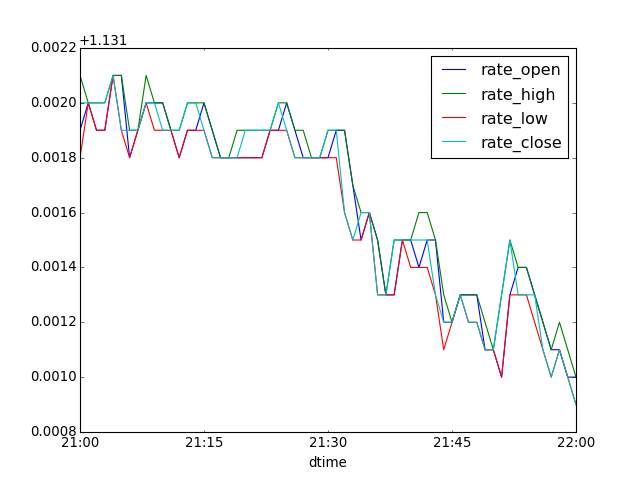

In [81]:
dt = datetime(2016, 4, 21, 21, 30, 0)
inter_dt = timedelta(days = 7)
delta = timedelta(minutes=30)
lower = str(dt - delta) 
upper = str(dt + delta)
selection = df.loc[lower:upper]
selection.plot.line()

In [52]:
df.index.is_monotonic_increasing

True

In [56]:
start = datetime.strptime('2014-01-02 14:07:00', '%Y-%m-%d %H:%M:%S')
end = datetime.strptime('2014-01-02 14:22:00', '%Y-%m-%d %H:%M:%S')
print df.loc[start:end]

Empty DataFrame
Columns: [rate_open, rate_high, rate_low, rate_close]
Index: []
